In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from scipy.stats import qmc 
import matplotlib.pyplot as plt
from matplotlib import cm 

device = torch.device("cuda:0" if torch.cuda.is_available() else"cpu")
print(device)

cuda:0


In [2]:
### generating data

# number of boundary and initial data points
# value `Nd` in the reference paper:
# Nd = number_of_ic_points + number_of_bc1_points + number_of_bc1_points 
number_of_ic_points = 100
number_of_bc1_points = 50
number_of_bc2_points = 50
# Latin Hypercube Sampling (LHS) engine ; to sample random points in domain,
# boundary and initial boundary
engine = qmc.LatinHypercube(d=1) #1차원 샘플을 만들어줄 엔진(인스턴스)생성

# temporal data points
t_d = engine.random(n=number_of_bc1_points + number_of_bc2_points)
temp = np.zeros([number_of_ic_points, 1]) # for IC ; t = 0
t_d = np.append(temp, t_d, axis=0)
# spatial data points
x_d = engine.random(n=number_of_ic_points)
x_d = (2*np.pi) * (x_d) #기본적으로 qmc는 0,1 사이의 난수를 생성 하므로 -1,1 범위로 난수 스케일링
temp1 = np.zeros([number_of_bc1_points, 1]) # for BC1 ; x = -1
temp2 = (2*np.pi) * np.ones([number_of_bc2_points, 1]) # for BC2 ; x = +1
x_d = np.append(x_d, temp1, axis=0)
x_d = np.append(x_d, temp2, axis=0)

#나중에 t_d, x_d를 합칠거니 이렇게 생성했고, 앞 50개는 초기조건, 뒤 50개는 경계조건 데이터

In [3]:
#output values for data points (boundary and initial)
y_d = np.zeros(x_d.shape)

# for initial condition: IC = -sin(pi*x)
y_d[ : number_of_ic_points] = 3*np.sin(2.5 * x_d[:number_of_ic_points])

# all boundary conditions are set to zero
y_d[number_of_ic_points : number_of_bc1_points + number_of_ic_points] = 0
y_d[number_of_bc1_points + number_of_ic_points : number_of_bc1_points + number_of_ic_points + number_of_bc2_points] = 0
     

# number of collocation points
Nc = 20000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)
# set x values between -1. and +1.
data[:, 1] = (2*np.pi)*(data[:, 1])

# change names
t_c = np.expand_dims(data[:, 0], axis=1)
x_c = np.expand_dims(data[:, 1], axis=1)
     

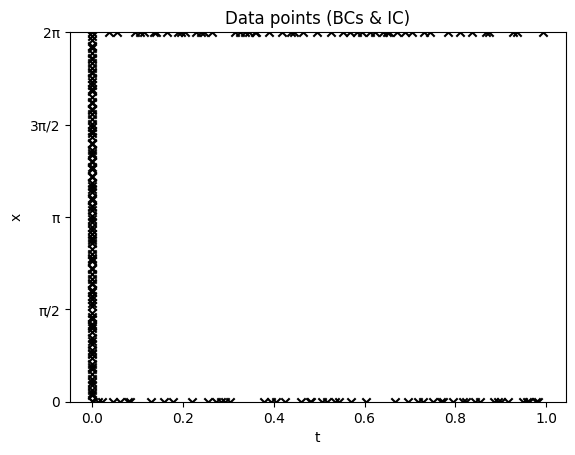

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot
plt.scatter(t_d, x_d, marker="x", c="k")

# Set axis labels and title
plt.xlabel("t")
plt.ylabel("x")
plt.title("Data points (BCs & IC)")

# Set y-axis range to 0 to 2*pi
plt.ylim(0, 2*np.pi)

# Set y-axis ticks to multiples of pi
plt.yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ["0", "π/2", "π", "3π/2", "2π"])

# Display the plot
plt.show()


In [5]:
class Net(nn.Module) :
    def __init__(self) :
        super(Net,self).__init__()
        self.hidden_layer1 = nn.Linear(2,64)
        self.hidden_layer2 = nn.Linear(64,64)
        self.hidden_layer3 = nn.Linear(64,64)
        self.hidden_layer4 = nn.Linear(64,64)
        self.hidden_layer5 = nn.Linear(64,64)
        self.output_layer = nn.Linear(64,1)
        
    def forward(self,x,t) :
        inputs = torch.cat([x,t],axis =1 )
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) 
        return output
    
    
"""
probably the quesion part is activation function. how about tanh??? or sin?
"""

'\nprobably the quesion part is activation function. how about tanh??? or sin?\n'

In [6]:
net = Net() # is what we defined and stands for net.
net = net.to(device) #is to send net calculation to device
mse_cos_function = torch.nn.MSELoss() #is mean squared error loss function
optimizer = torch.optim.Adam(net.parameters()) # is for optimizer name Adam for parameters in our model.


In [7]:
def f(x,t,net) :
    u = net(x,t) # is to let u is given by the network based on independent variables x,t. so we need u_t and u_x
    #define u_t and u_x
    
    u_x = torch.autograd.grad(u.sum(),x,create_graph=True)[0] 
    u_t = torch.autograd.grad(u.sum(),t,create_graph=True)[0] 
    u_xx = torch.autograd.grad(u_x.sum(),x,create_graph=True)[0]
    pde = u_t - u_xx
    return pde

In [8]:
iterations = 40000
previous_validation_loss=99999999.0
loss_log=[]
for epoch in range(iterations) :
    optimizer.zero_grad()
    
    #loss based on bc
    
    pt_x_d = Variable(torch.from_numpy(x_d).float(),requires_grad=False).to(device)
    pt_t_d = Variable(torch.from_numpy(t_d).float(),requires_grad=False).to(device) 
    pt_y_d = Variable(torch.from_numpy(y_d).float(),requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_d,pt_t_d)
    mse_u = mse_cos_function(net_bc_out,pt_y_d)
    
    
    
    #loss based on PDE
    
 
    all_zeros = np.zeros((Nc,1))
    
    pt_x_c = Variable(torch.from_numpy(x_c).float(),requires_grad=True).to(device)
    pt_t_c = Variable(torch.from_numpy(t_c).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_c,pt_t_c,net)
    mse_f = mse_cos_function(f_out,pt_all_zeros)
    
    loss = mse_u+ mse_f
    
    loss.backward()
    
    optimizer.step()
    
    with torch.autograd.no_grad():
        print(epoch,"training loss",loss.data)
    loss_log.append(loss)

0 training loss tensor(2.3111, device='cuda:0')
1 training loss tensor(2.2639, device='cuda:0')
2 training loss tensor(2.2393, device='cuda:0')
3 training loss tensor(2.2325, device='cuda:0')
4 training loss tensor(2.2341, device='cuda:0')
5 training loss tensor(2.2337, device='cuda:0')
6 training loss tensor(2.2290, device='cuda:0')
7 training loss tensor(2.2224, device='cuda:0')
8 training loss tensor(2.2169, device='cuda:0')
9 training loss tensor(2.2140, device='cuda:0')
10 training loss tensor(2.2133, device='cuda:0')
11 training loss tensor(2.2135, device='cuda:0')
12 training loss tensor(2.2132, device='cuda:0')
13 training loss tensor(2.2117, device='cuda:0')
14 training loss tensor(2.2093, device='cuda:0')
15 training loss tensor(2.2068, device='cuda:0')
16 training loss tensor(2.2049, device='cuda:0')
17 training loss tensor(2.2041, device='cuda:0')
18 training loss tensor(2.2041, device='cuda:0')
19 training loss tensor(2.2042, device='cuda:0')
20 training loss tensor(2.2035

In [9]:
import torch
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

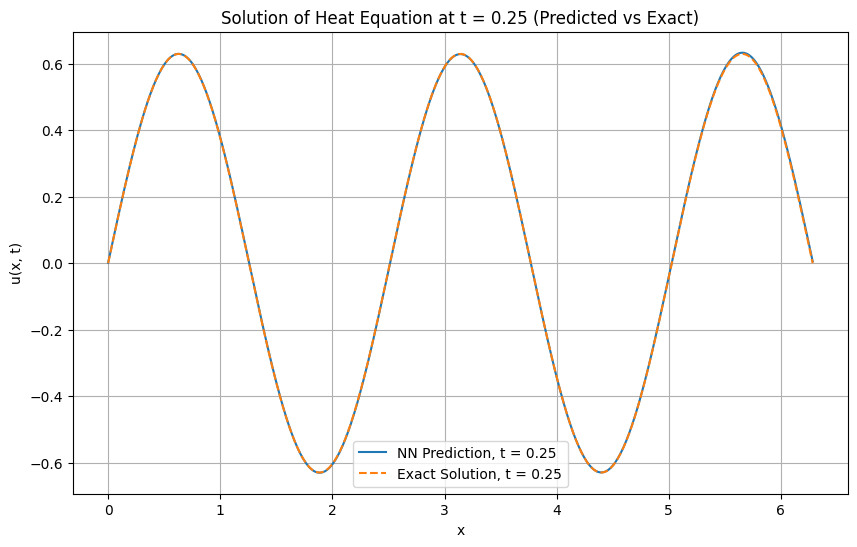

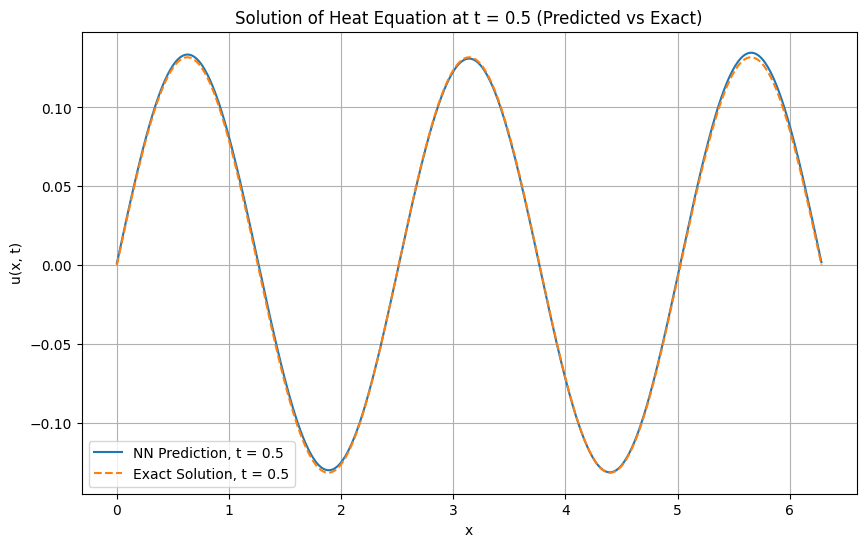

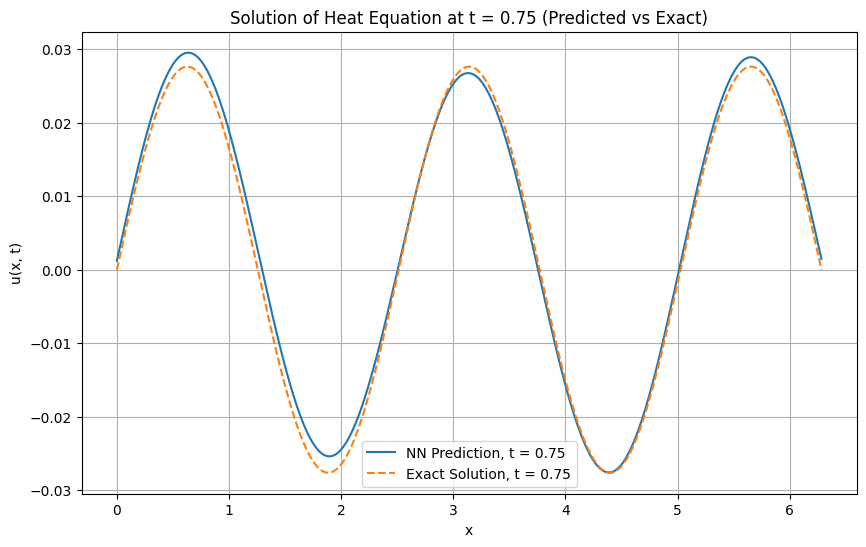

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to plot the solution of the Heat Equation at specific times
def plot_solution_at_times_with_exact(net, x_values, t_values, device):
    net.eval()  # Put the network in evaluation mode

    for t in t_values:
        plt.figure(figsize=(10, 6))
        
        # Prepare x and t inputs
        t_fixed = np.full((x_values.shape[0], 1), t)
        pt_x = torch.from_numpy(x_values).float().to(device)
        pt_t = torch.from_numpy(t_fixed).float().to(device)

        # Predict u(x, t) using the trained network
        with torch.no_grad():
            u_pred = net(pt_x, pt_t)
            u_pred = u_pred.cpu().numpy()  # Convert back to NumPy

        # Calculate the exact solution for comparison
        exact_solution = 3 * np.sin(5 * x_values / 2) * np.exp(-(5 / 2) ** 2 * t)

        # Plot u(x, t) for this specific t
        plt.plot(x_values, u_pred, label=f"NN Prediction, t = {t}")
        plt.plot(x_values, exact_solution, label=f"Exact Solution, t = {t}", linestyle='--')

        plt.title(f"Solution of Heat Equation at t = {t} (Predicted vs Exact)")
        plt.xlabel("x")
        plt.ylabel("u(x, t)")
        plt.legend()
        plt.grid(True)
        plt.show()

# Define the x-values and t-values for evaluation
x_values = np.linspace(0, 2*np.pi, 500).reshape(-1, 1)  # 500 points in x (from 0 to 2*pi)
t_values = [0.25, 0.5, 0.75]  # Specific time points

# Plot the solution (assuming `net` is your trained model and `device` is your computation device)
plot_solution_at_times_with_exact(net, x_values, t_values, device)
